# Context Aware Song Recommender

### Additional Relevant Features to Extract from Google Maps Data
1. Time of Day: Different times (morning, afternoon, evening, night) can correlate with different music preferences. - segment into different time slots
2. Day of the Week: Similar to the weekend feature, different days might affect mood and music choice. - OHE all the days ++ is weekend or not
3. Weather Conditions: If accessible, current weather conditions (sunny, rainy, snowy) could influence music preferences. - AND ALSO is nighttime / is daytime
4. Location Type / POIs: Categorize locations (e.g., gym, park, restaurant, shopping mall) to understand context-specific preferences - AND just OHE some important POIs
5. Distance Traveled: The distance between locations could indicate if the user is on a long journey, which might affect music preferences.
5a. -distance from HOME
6. Activity Duration: The length of time spent at a location or traveling can indicate different needs for music (short vs. long playlists).
7. Social Context: Detect if the user is in a group setting versus alone, which might change music preferences.
8. Previous Locations: Track sequence of visited locations to detect patterns (e.g., regular routes, favorite spots).
9. Speed: Determine if the user is walking, running, cycling, driving, etc., based on the speed between locations. - OHE
10. Event Participation: Identify if the user is near or attending an event (concerts, sports events, festivals).
13. Geographical Features: Identify urban vs. rural areas, proximity to natural features (parks, beaches).
14. Traffic Conditions: Heavy traffic might affect the user’s mood and music choice.
15. Recurring Locations: Identify frequently visited locations to understand routine and habitual behaviors.
16. Special Days: Detect holidays, birthdays, and anniversaries which might influence music choice.

## Step 1: Data Preprocessing!

1. We retrieved the music listening history from lastfm. This is loaded in as listening_history.
2. We also have a database of song quality traits that we will use as the features for the final song vector. This is loaded in as song_features. 

In [1]:
import pandas as pd

In [2]:
listening_history = pd.read_csv('./csv_data/listening_history.csv')
listening_history.head()

,Artist,Album,Song,Date Played
0,Drake,Views,One Dance,2024-07-07 23:10
1,A$AP Rocky,TESTING,Praise the Lord (Da Shine) (feat. Skepta),2024-07-07 23:06
2,Travis Scott,ASTROWORLD,SICKO MODE,2024-07-07 23:01
3,Kanye West,Donda,Hurricane,2024-07-07 22:57
4,Gunna,WUNNA,DOLLAZ ON MY HEAD (feat. Young Thug),2024-07-07 22:54


In [3]:
song_features = pd.read_csv('./csv_data/song_features.csv')
song_features.head()

,Artist,Album,Song,Song ID,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Drake,Views,One Dance,1zi7xx7UVEFkmKfv06H8x0,0.792,0.625,1,-5.609,1,0.0536,0.00776,0.0018,0.329,0.370,103.967,173987,4
1,A$AP Rocky,TESTING,Praise the Lord (Da Shine) (feat. Skepta),7ycWLEP1GsNjVvcjawXz3z,0.854,0.569,5,-8.151,0,0.1060,0.06090,0.0816,0.100,0.294,80.015,205040,4
2,Travis Scott,ASTROWORLD,SICKO MODE,2xLMifQCjDGFmkHkpNLD9h,0.834,0.730,8,-3.714,1,0.2220,0.00513,0.0000,0.124,0.446,155.008,312820,4
3,Kanye West,Donda,Hurricane,6Hfu9sc7jvv6coyy2LlzBF,0.587,0.561,0,-6.569,1,0.1460,0.04660,0.0000,0.109,0.351,80.009,243187,4
4,Gunna,WUNNA,DOLLAZ ON MY HEAD (feat. Young Thug),3nS9a01VvXHQriLqJYwRqG,0.825,0.458,0,-7.470,1,0.0577,0.11400,0.0000,0.102,0.161,145.115,197760,4


In [4]:
personal_data = pd.merge(listening_history, song_features, on=['Artist', 'Song'], how='left')
personal_data = personal_data.drop(columns=['Album_y'])
personal_data = personal_data.rename(columns={"Album_x": "Album"})
personal_data.head()

personal_data['Date Played'] = pd.to_datetime(personal_data['Date Played'])
personal_data.set_index('Date Played', inplace=True)
# exporting this data to a csv in case I need it later
# personal_data.to_csv('./csv_data/personal_data.csv', index=False)

In [5]:
# we drop rows that do not have any feature data
print(len(personal_data))
personal_data = personal_data.dropna(subset=['danceability'])
print(len(personal_data))

# this should output as 0
personal_data.isnull().sum()

68073
68071


Artist              0
Album               0
Song                0
Song ID             0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
dtype: int64

In [6]:
personal_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,68071.000000,68071.000000,68071.000000,68071.000000,68071.000000,68071.00000,68071.000000,68071.000000,68071.000000,68071.000000,68071.000000,6.807100e+04,68071.000000
mean,0.612184,0.524739,5.077199,-9.990134,0.532620,0.13133,0.358798,0.208853,0.193924,0.386051,120.666550,2.033941e+05,3.908786
std,0.188328,0.242541,3.573734,6.963899,0.498938,0.12057,0.341168,0.359805,0.149048,0.225117,31.523888,8.234364e+04,0.454264
min,0.000000,0.000257,0.000000,-48.781000,0.000000,0.00000,0.000001,0.000000,0.021600,0.000000,0.000000,3.100000e+04,0.000000
25%,0.505000,0.389000,1.000000,-11.073000,0.000000,0.04400,0.051800,0.000000,0.103000,0.204000,93.372000,1.533330e+05,4.000000
50%,0.634000,0.550000,5.000000,-7.770000,1.000000,0.07390,0.231000,0.000021,0.129000,0.363000,120.146000,1.971320e+05,4.000000
75%,0.755000,0.703000,8.000000,-5.746000,1.000000,0.19100,0.654000,0.268000,0.248000,0.542000,145.157000,2.439760e+05,4.000000
max,0.979000,1.000000,11.000000,0.919000,1.000000,0.96100,0.996000,0.997000,0.991000,0.998000,248.794000,1.493875e+06,5.000000


# Exploratory Data Analysis

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

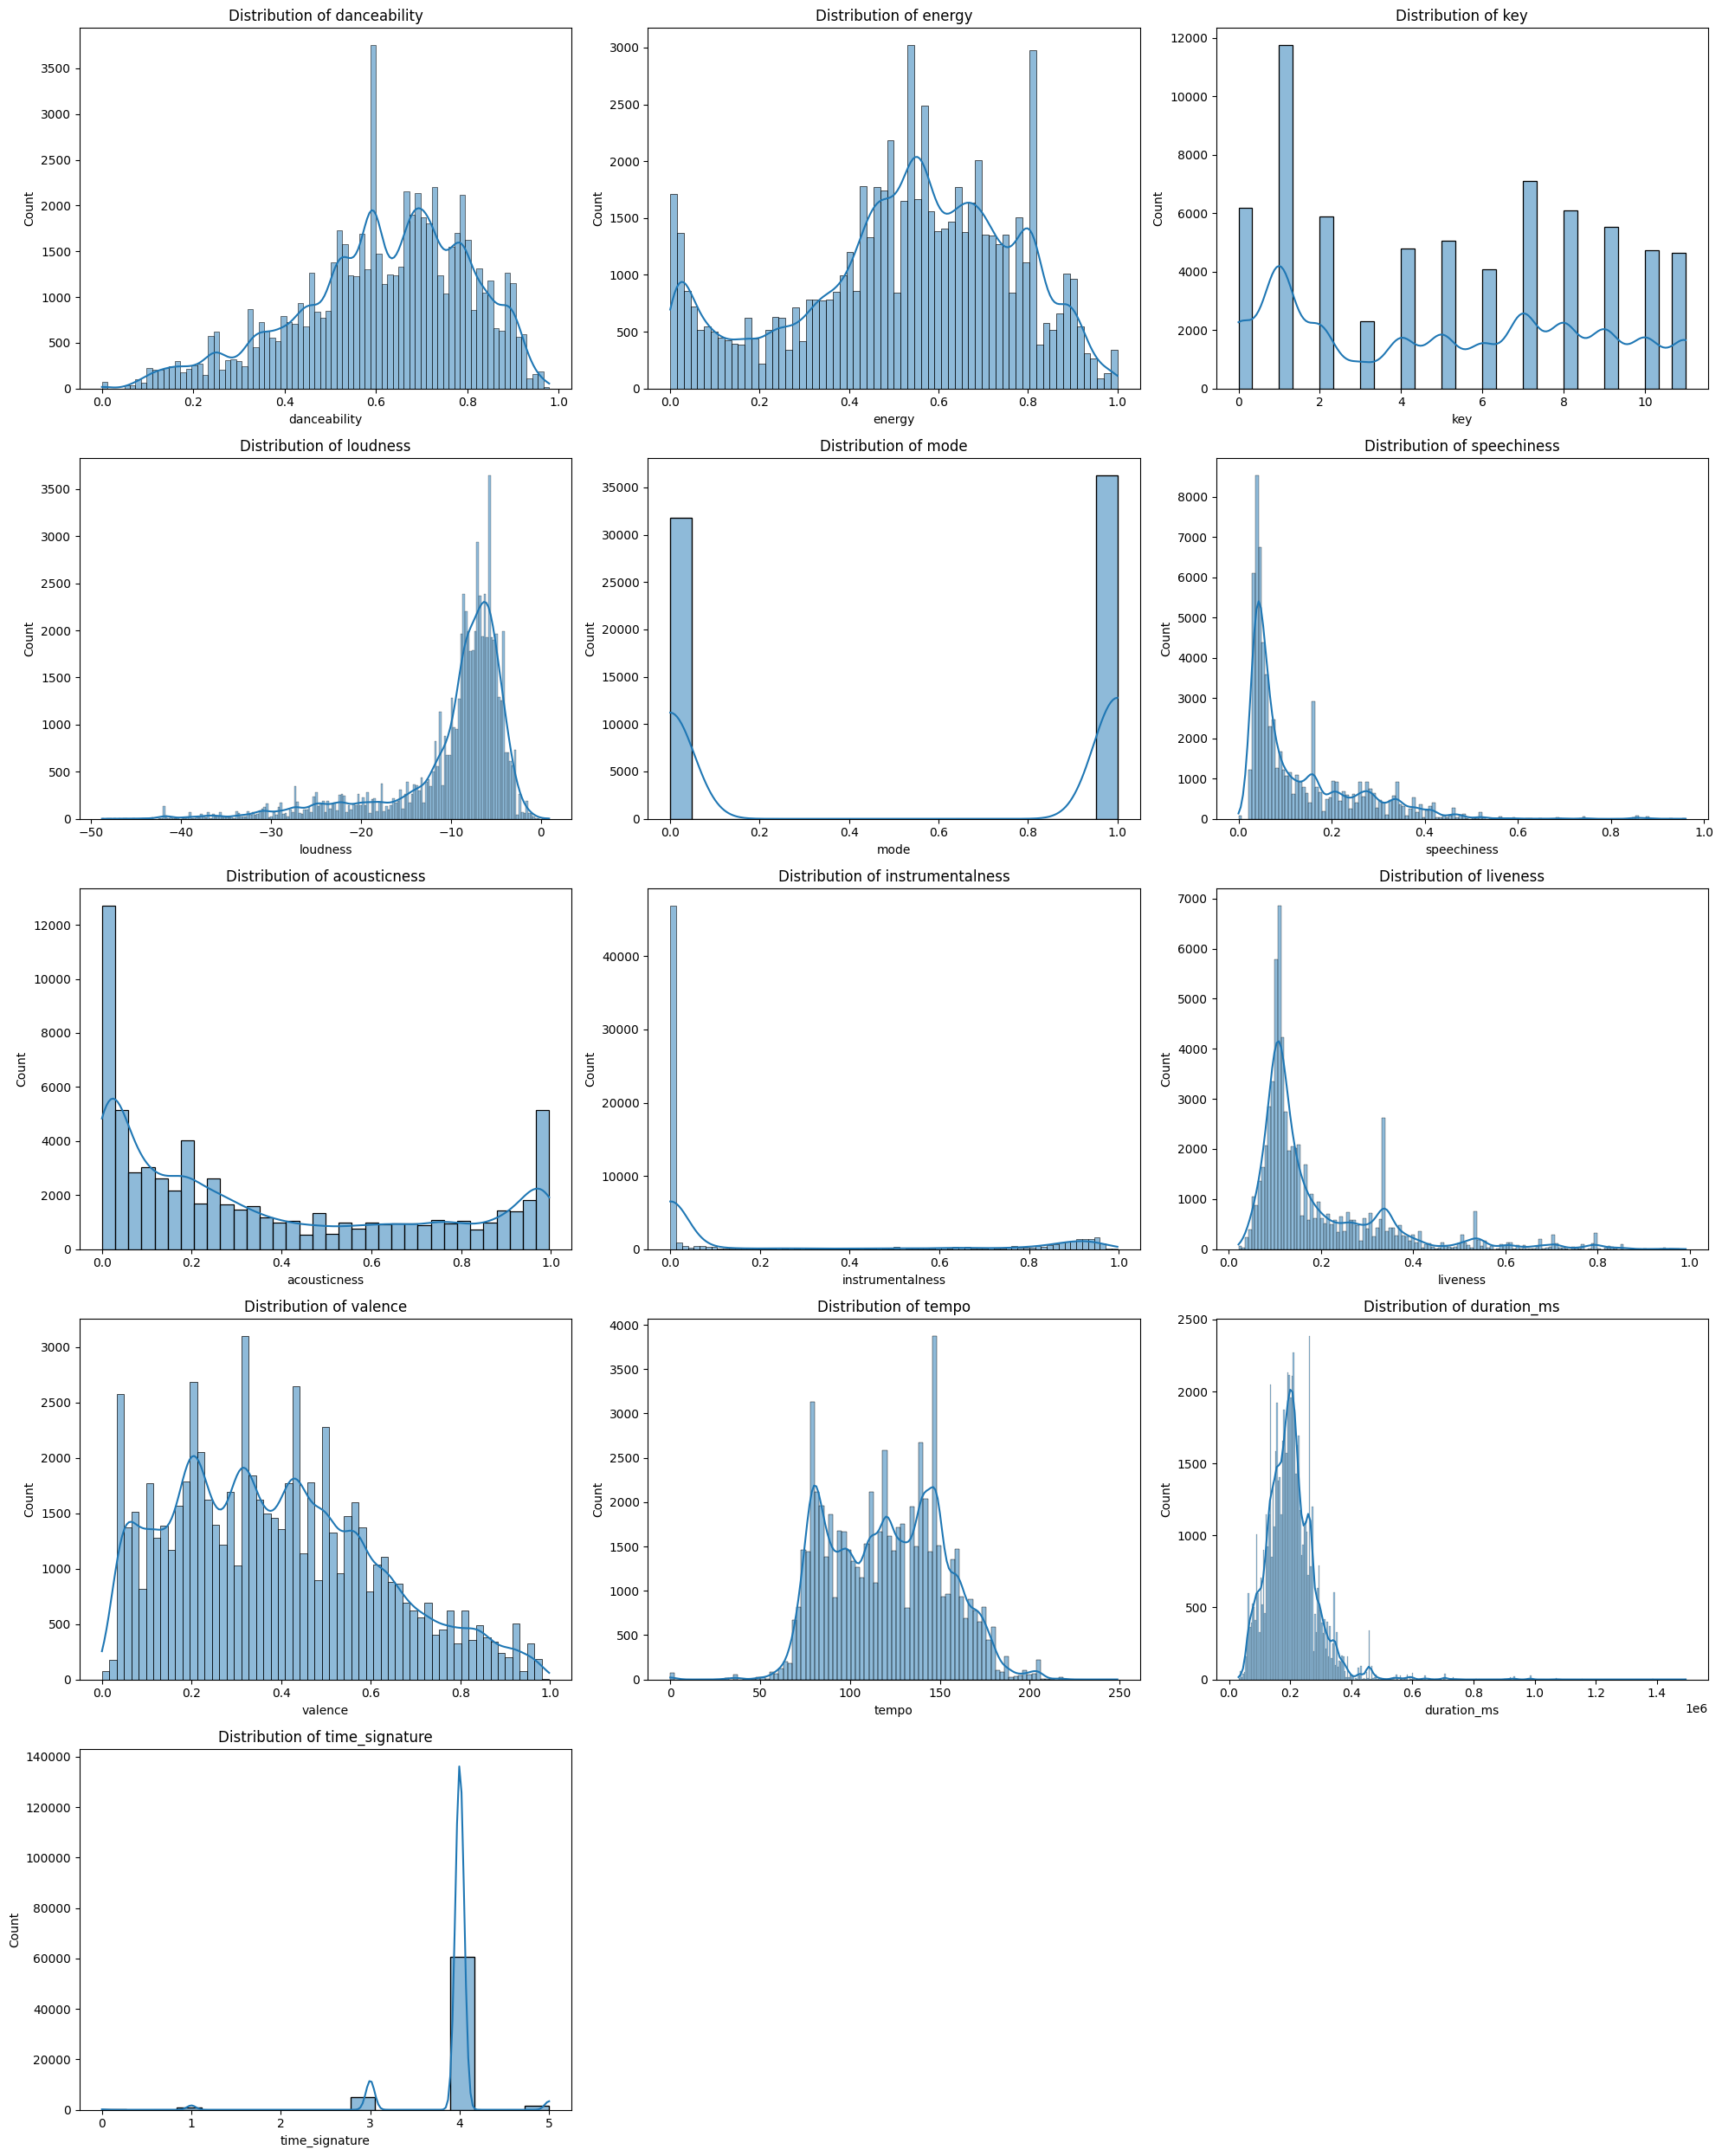

In [8]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# Number of features
num_features = len(features)

# Number of rows and columns for the subplots
num_cols = 3  # You can adjust this number based on how you want to layout the plots
num_rows = (num_features + num_cols - 1) // num_cols  # Ceiling division

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(features):
    sns.histplot(personal_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

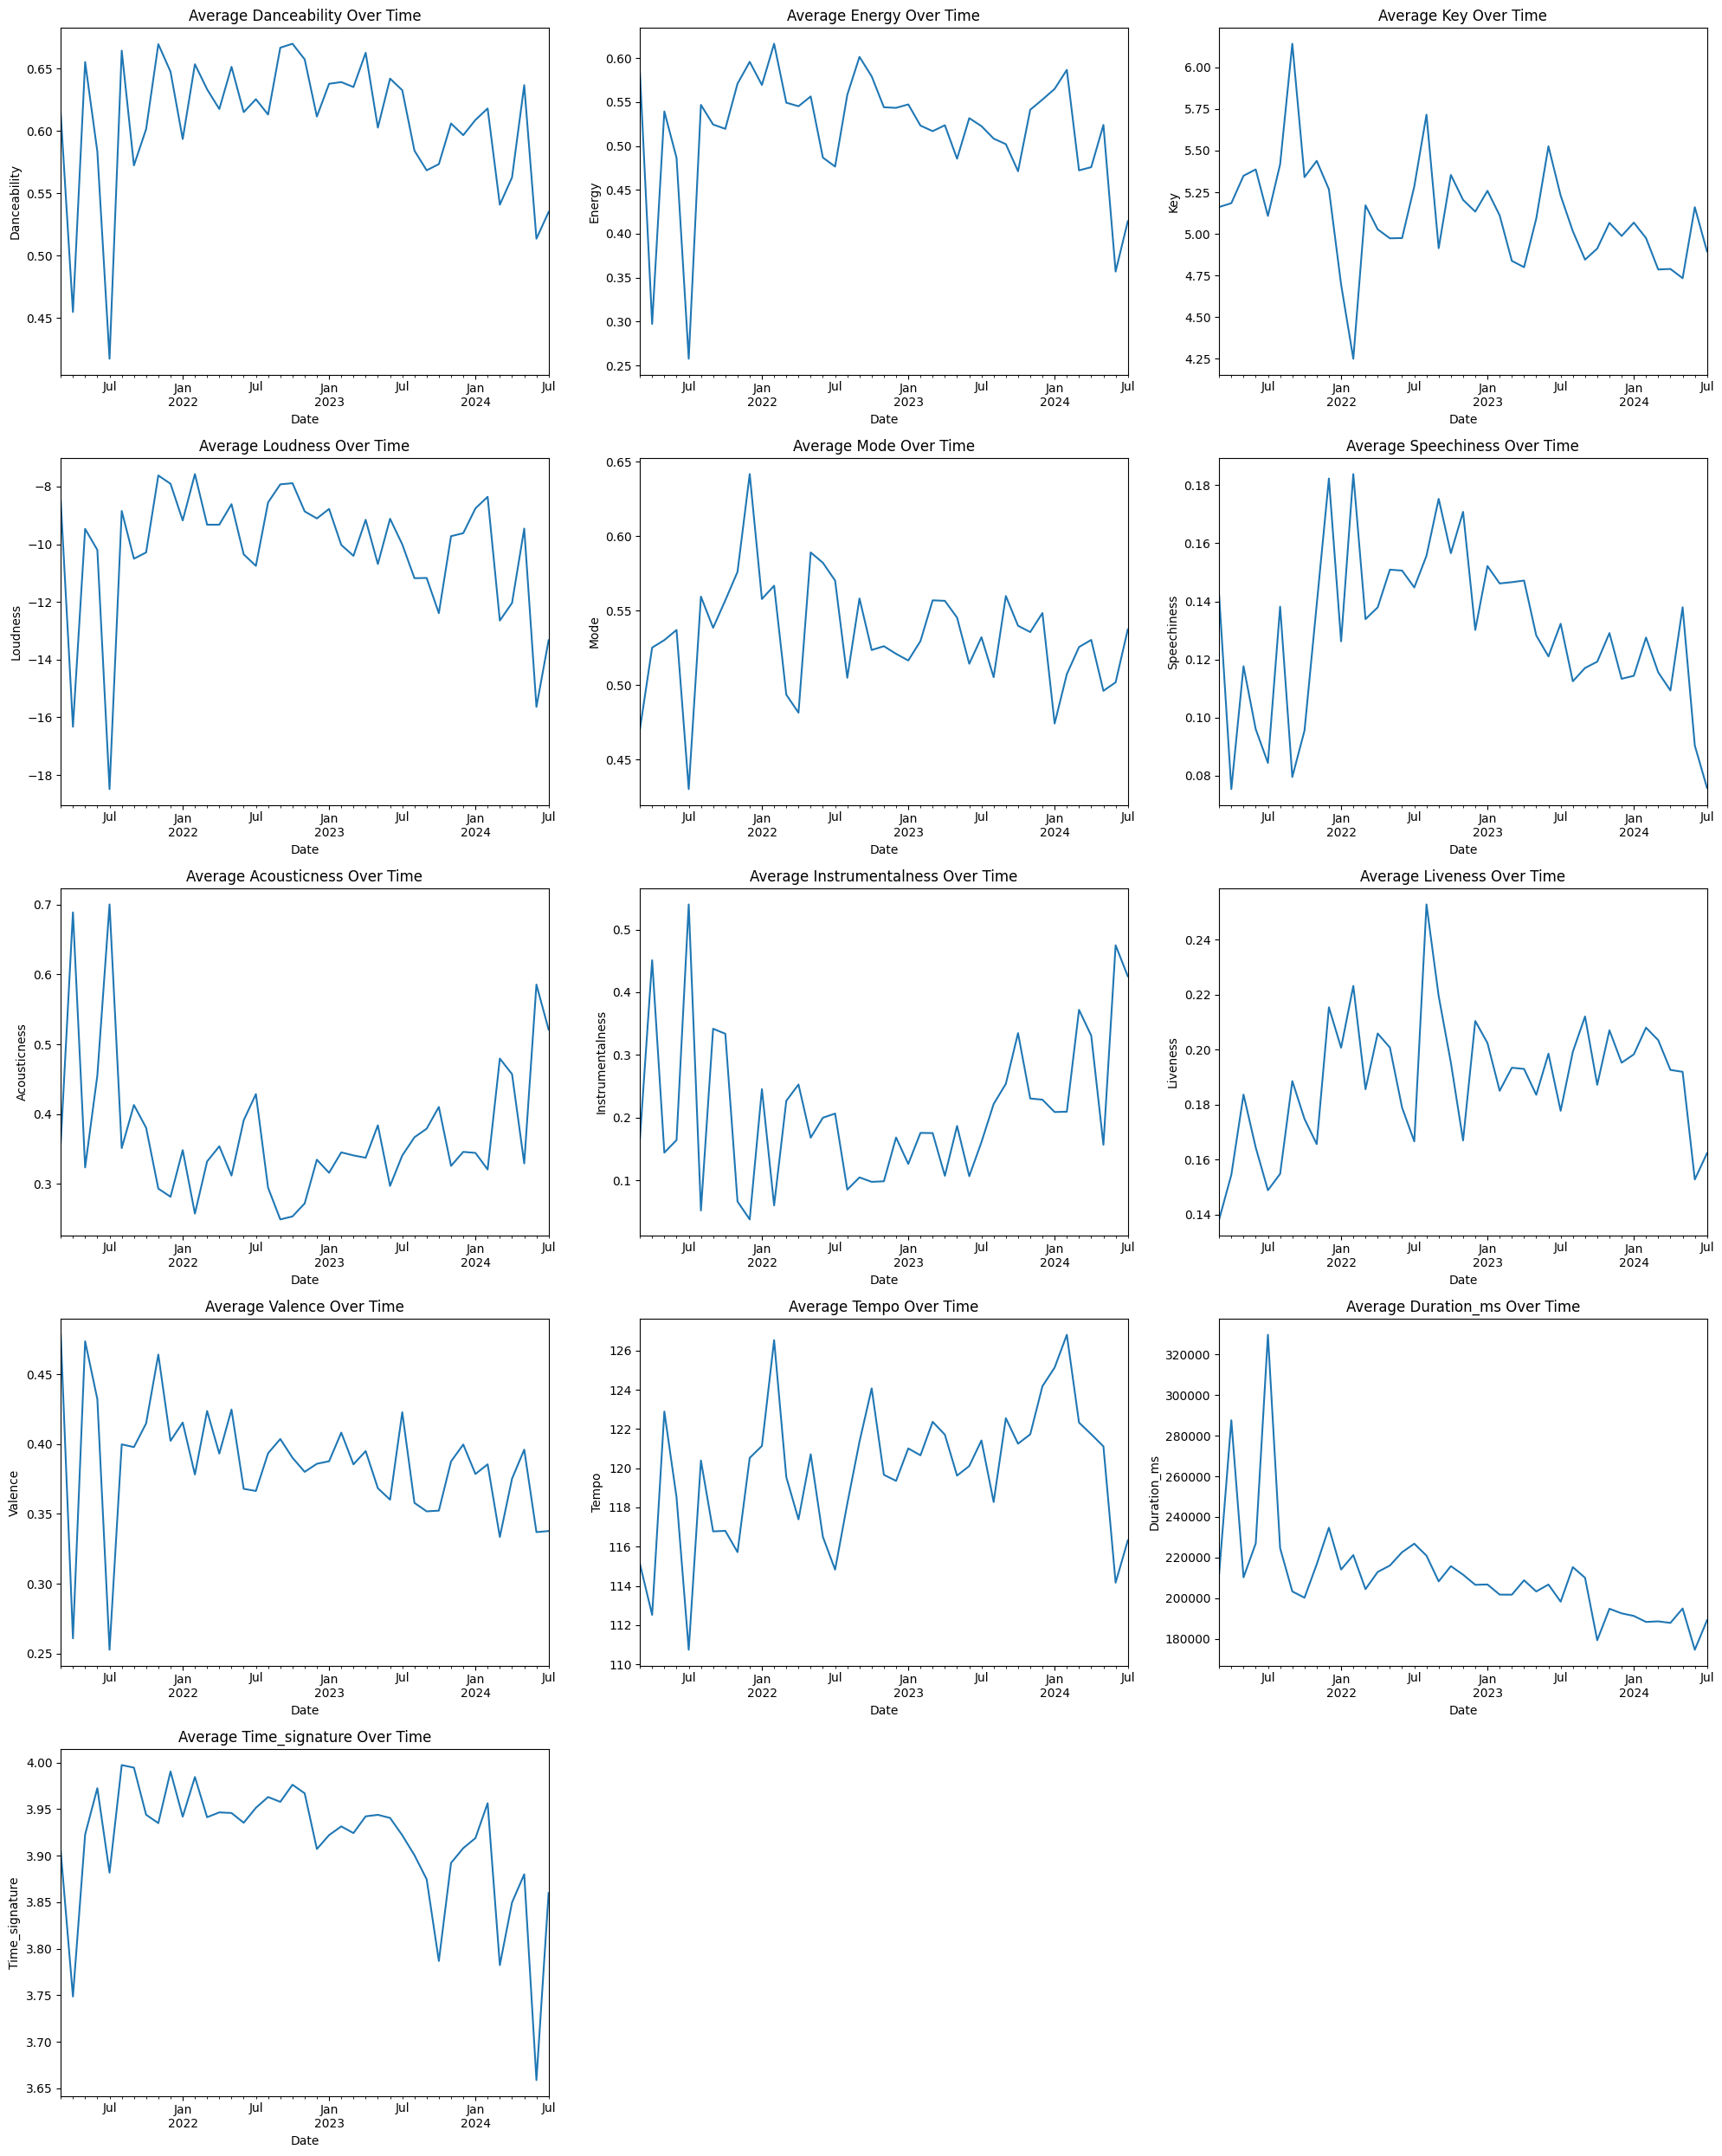

In [9]:
# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a subplot
for i, feature in enumerate(features):
    personal_data[feature].resample('ME').mean().plot(ax=axes[i])
    axes[i].set_title(f'Average {feature.capitalize()} Over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(feature.capitalize())

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

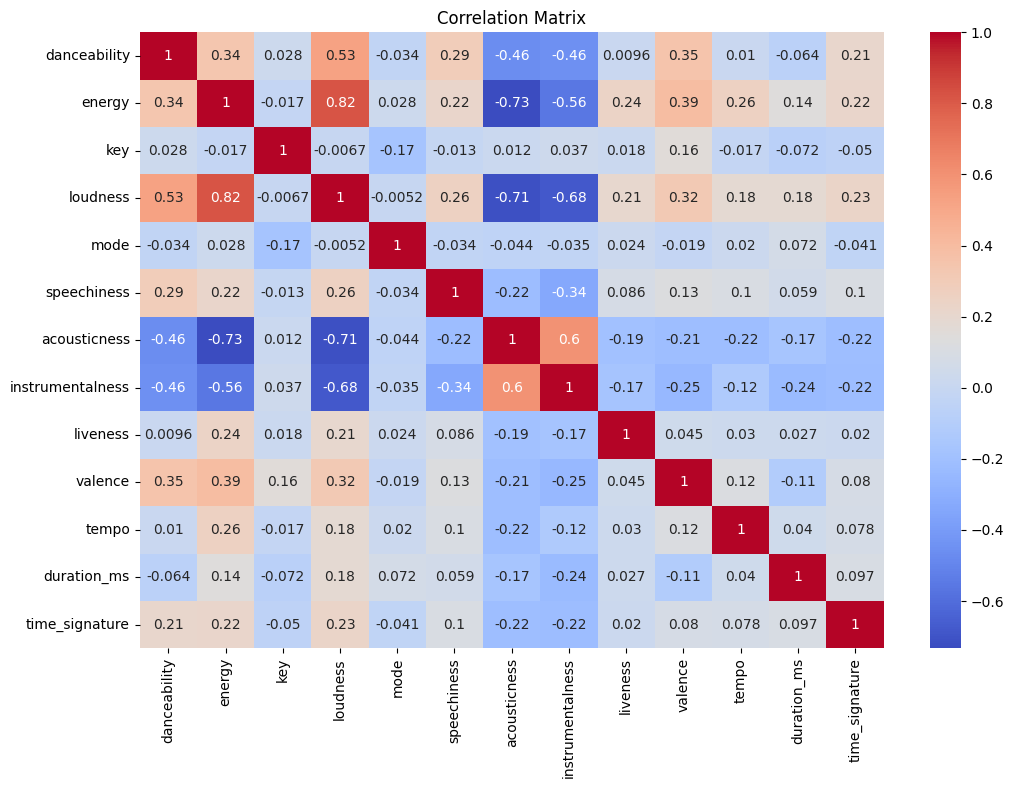

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(personal_data[features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Weekend / Weekday Analysis 

<Figure size 1500x1000 with 0 Axes>

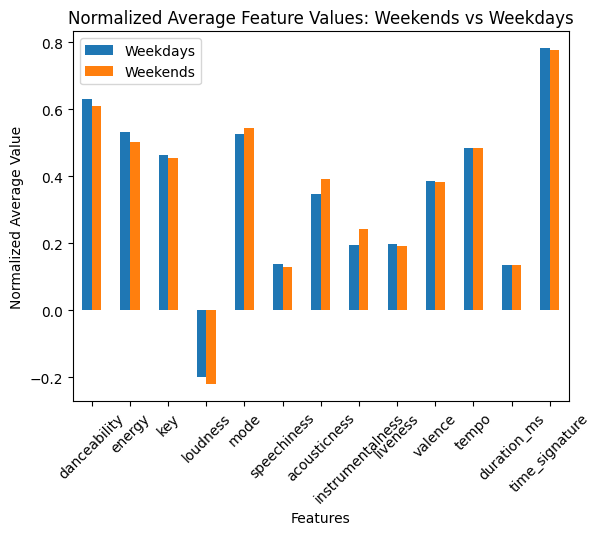

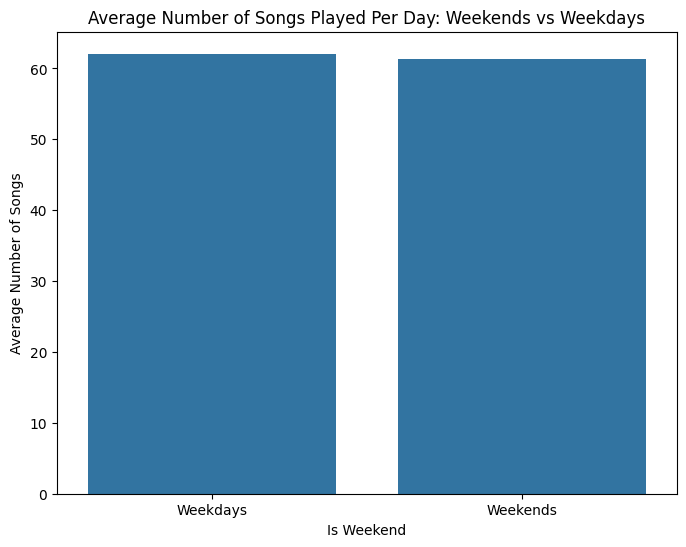

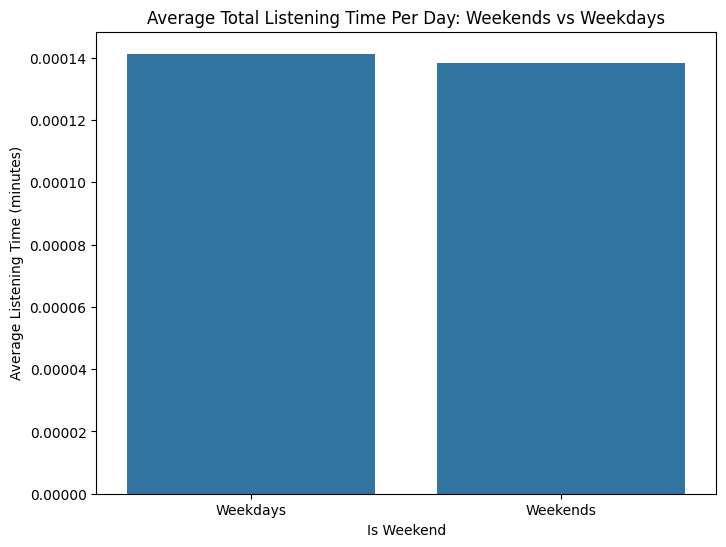

In [11]:
personal_data.index = pd.to_datetime(personal_data.index)

# Add a new column to indicate if it's a weekend or weekday
personal_data['is_weekend'] = personal_data.index.dayofweek >= 5

# List of features to normalize
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# Normalize feature values to have a maximum value of 1
personal_data[features] = personal_data[features].apply(lambda x: x / abs(x).max())

# Calculate average feature values for weekends vs weekdays
average_features = personal_data.groupby('is_weekend')[features].mean().reset_index()

# Plot average feature values comparison
plt.figure(figsize=(15, 10))
average_features.set_index('is_weekend').T.plot(kind='bar')
plt.title('Normalized Average Feature Values: Weekends vs Weekdays')
plt.xlabel('Features')
plt.ylabel('Normalized Average Value')
plt.xticks(rotation=45)
plt.legend(['Weekdays', 'Weekends'])
plt.show()

# Calculate the number of songs played per day on weekends vs weekdays
personal_data['day'] = personal_data.index.date
songs_per_day = personal_data.groupby(['day', 'is_weekend']).size().reset_index(name='song_count')

# Calculate average number of songs played per day
average_songs_per_day = songs_per_day.groupby('is_weekend')['song_count'].mean().reset_index()

# Plot average number of songs played per day comparison
plt.figure(figsize=(8, 6))
sns.barplot(x='is_weekend', y='song_count', data=average_songs_per_day)
plt.title('Average Number of Songs Played Per Day: Weekends vs Weekdays')
plt.xlabel('Is Weekend')
plt.ylabel('Average Number of Songs')
plt.xticks([0, 1], ['Weekdays', 'Weekends'])
plt.show()

# Calculate total listening time per day on weekends vs weekdays
personal_data['listening_time'] = personal_data['duration_ms'] / 60000  # Convert duration from ms to minutes
listening_time_per_day = personal_data.groupby(['day', 'is_weekend'])['listening_time'].sum().reset_index()

# Calculate average total listening time per day
average_listening_time_per_day = listening_time_per_day.groupby('is_weekend')['listening_time'].mean().reset_index()

# Plot average total listening time per day comparison
plt.figure(figsize=(8, 6))
sns.barplot(x='is_weekend', y='listening_time', data=average_listening_time_per_day)
plt.title('Average Total Listening Time Per Day: Weekends vs Weekdays')
plt.xlabel('Is Weekend')
plt.ylabel('Average Listening Time (minutes)')
plt.xticks([0, 1], ['Weekdays', 'Weekends'])
plt.show()

## Let's Get some Location Data

100%|██████████| 1461377/1461377 [00:01<00:00, 1115557.24it/s]


         latitudeE7  longitudeE7                 timestamp    activity
0         43.801210   -79.349083 2017-02-19 04:03:00+00:00       STILL
1         43.801213   -79.349086 2017-02-19 04:05:00+00:00       STILL
2         43.801236   -79.348904 2017-02-19 04:07:00+00:00       STILL
3         43.801184   -79.349049 2017-02-19 04:09:00+00:00       STILL
4         43.801215   -79.349017 2017-02-19 04:10:00+00:00       STILL
...             ...          ...                       ...         ...
1461372   43.796609   -79.361155 2024-06-20 00:48:00+00:00       STILL
1461373   43.796609   -79.361155 2024-06-20 00:48:00+00:00       STILL
1461374   43.798239   -79.356588 2024-06-20 00:51:00+00:00  ON_BICYCLE
1461375   43.799585   -79.354186 2024-06-20 00:52:00+00:00       STILL
1461376   43.800470   -79.350189 2024-06-20 00:54:00+00:00  ON_BICYCLE

[1461377 rows x 4 columns]


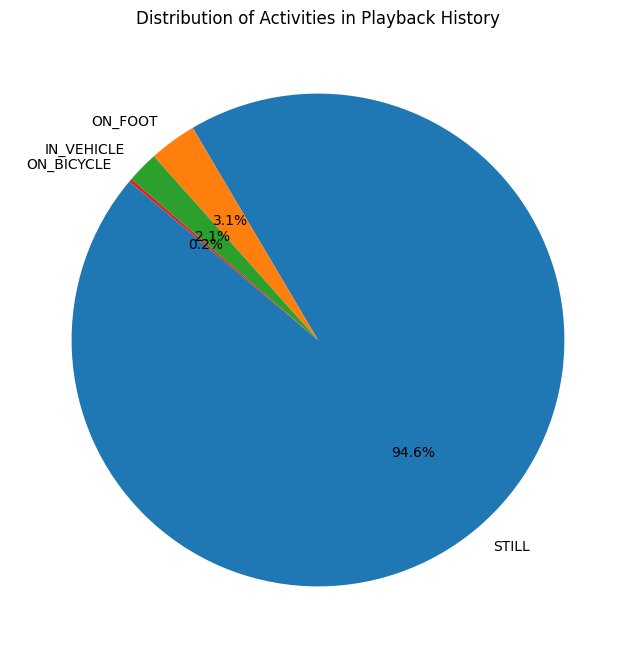

In [1]:
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the JSON data from the file
with open('Records.json', 'r') as file:
    data = json.load(file)

# Initialize lists to store the extracted data
latitudeE7 = []
longitudeE7 = []
timestamps = []
activities = []

# Iterate over each location in the JSON data
for location in tqdm(data['locations']):
    latitudeE7.append(location.get('latitudeE7', None))
    longitudeE7.append(location.get('longitudeE7', None))
    timestamps.append(location.get('timestamp', None))
    
    # Extract the activity with the highest confidence, if available
    if 'activity' in location and location['activity']:
        # Assume the first activity entry has the highest confidence

        still_activities = ['TILTING', 'UNKNOWN']

        main_activity = location['activity'][0]['activity'][0]['type']
        if main_activity in still_activities:
            main_activity = 'STILL'
        
        if main_activity == 'EXITING_VEHICLE':
            main_activity = 'IN_VEHICLE'
    else:
        # Default to "STILL" if no activity is listed
        main_activity = 'STILL'
    activities.append(main_activity)

# Create the DataFrame
location_data = pd.DataFrame({
    'latitudeE7': latitudeE7,
    'longitudeE7': longitudeE7,
    'timestamp': timestamps,
    'activity': activities
})


location_data['latitudeE7'] = location_data['latitudeE7'] / 10**7
location_data['longitudeE7'] = location_data['longitudeE7'] / 10**7

location_data['timestamp'] = pd.to_datetime(location_data['timestamp'], format='ISO8601')
location_data['timestamp'] = location_data['timestamp'].dt.round('min')

# Display the DataFrame
print(location_data)

activity_counts = location_data['activity'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(activity_counts, labels=activity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Activities in Playback History')
plt.show()

In [2]:
location_data = pd.get_dummies(location_data, columns=['activity'], dtype=float)
location_data.head()

,latitudeE7,longitudeE7,timestamp,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL
0,43.801210,-79.349083,2017-02-19 04:03:00+00:00,0.0,0.0,0.0,1.0
1,43.801213,-79.349086,2017-02-19 04:05:00+00:00,0.0,0.0,0.0,1.0
2,43.801236,-79.348904,2017-02-19 04:07:00+00:00,0.0,0.0,0.0,1.0
3,43.801184,-79.349049,2017-02-19 04:09:00+00:00,0.0,0.0,0.0,1.0
4,43.801215,-79.349017,2017-02-19 04:10:00+00:00,0.0,0.0,0.0,1.0


In [3]:
# first we prepare the song data
song_data = pd.read_csv('./csv_data/personal_data.csv')

song_data['Date Played'] = pd.to_datetime(song_data['Date Played'])


song_data['Date Played'] = song_data['Date Played'].dt.tz_localize('UTC')

song_data = song_data.iloc[::-1].reset_index(drop=True)
song_data = song_data[['Song ID', 'Date Played']]

print(song_data)

                      Song ID               Date Played
0      5v9qXmcXDJTpBKCNBuWK3w 2021-03-12 16:47:00+00:00
1      5URRkOSTiK6ptNimcb3mDl 2021-03-12 16:52:00+00:00
2      6cT2ovEBYIdVIdjRM532dp 2021-03-12 16:56:00+00:00
3      25m7tvekS96VV5xZ5hyuP3 2021-03-12 16:58:00+00:00
4      4heEsW3208sXdv2hRLvFl9 2021-03-12 17:02:00+00:00
...                       ...                       ...
68068  3nS9a01VvXHQriLqJYwRqG 2024-07-07 22:54:00+00:00
68069  6Hfu9sc7jvv6coyy2LlzBF 2024-07-07 22:57:00+00:00
68070  2xLMifQCjDGFmkHkpNLD9h 2024-07-07 23:01:00+00:00
68071  7ycWLEP1GsNjVvcjawXz3z 2024-07-07 23:06:00+00:00
68072  1zi7xx7UVEFkmKfv06H8x0 2024-07-07 23:10:00+00:00

[68073 rows x 2 columns]


In [4]:
from tqdm import tqdm
import pandas as pd

# Ensure timestamp columns are datetime with the same timezone
song_data['Date Played'] = pd.to_datetime(song_data['Date Played'], utc=True)
location_data['timestamp'] = pd.to_datetime(location_data['timestamp'], utc=True)

# Create a new column in song_data to store the nearest location timestamp
song_data['nearest_location_time'] = pd.NaT

# Initialize pointer for location data
loc_idx = 0

# Iterate through song data
for i, song_row in tqdm(song_data.iterrows(), total=song_data.shape[0]):
    # Move the pointer forward in location data to find the nearest past timestamp
    while loc_idx < len(location_data) - 1 and location_data['timestamp'].iloc[loc_idx] < song_row['Date Played']:
        loc_idx += 1
    # Check the current and previous location timestamps to find the nearest
    if loc_idx == 0:
        nearest_location_idx = loc_idx
    else:
        prev_idx = loc_idx - 1
        if abs(location_data['timestamp'].iloc[prev_idx] - song_row['Date Played']) <= abs(location_data['timestamp'].iloc[loc_idx] - song_row['Date Played']):
            nearest_location_idx = prev_idx
        else:
            nearest_location_idx = loc_idx
    song_data.at[i, 'nearest_location_time'] = location_data.at[nearest_location_idx, 'timestamp']
    loc_idx = nearest_location_idx

# Ensure the new nearest_location_time column is datetime with the same timezone
song_data['nearest_location_time'] = pd.to_datetime(song_data['nearest_location_time'], utc=True)

# Merge song data with location data on the nearest location timestamp
playback_history = pd.merge(song_data, location_data, left_on='nearest_location_time', right_on='timestamp', how='left')

# Drop duplicate timestamp column
playback_history.drop(columns=['timestamp'], inplace=True)


  0%|          | 0/68073 [00:00<?, ?it/s]C:\Users\allan\AppData\Local\Temp\ipykernel_27560\3707035249.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2021-03-12 15:55:00+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  song_data.at[i, 'nearest_location_time'] = location_data.at[nearest_location_idx, 'timestamp']
100%|██████████| 68073/68073 [00:35<00:00, 1944.14it/s]


In [5]:
playback_history.to_csv('./csv_data/playback_history.csv', index=False)
playback_history.head()

,Song ID,Date Played,nearest_location_time,latitudeE7,longitudeE7,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL
0,5v9qXmcXDJTpBKCNBuWK3w,2021-03-12 16:47:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0
1,5URRkOSTiK6ptNimcb3mDl,2021-03-12 16:52:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0
2,6cT2ovEBYIdVIdjRM532dp,2021-03-12 16:56:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0
3,25m7tvekS96VV5xZ5hyuP3,2021-03-12 16:58:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0
4,4heEsW3208sXdv2hRLvFl9,2021-03-12 17:02:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0


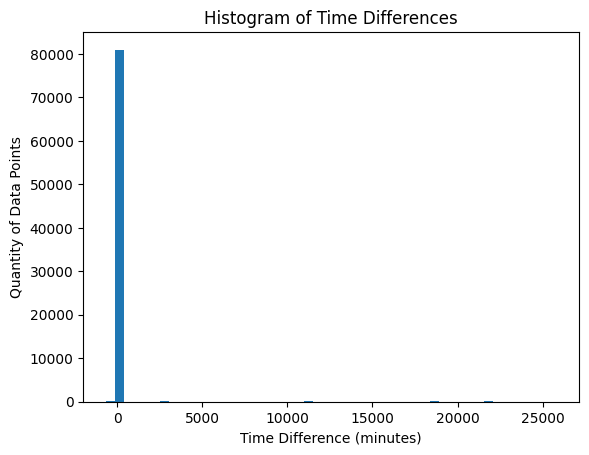

In [6]:
import matplotlib.pyplot as plt

see_time_difference = pd.DataFrame()

# Calculate the time difference
see_time_difference['time_difference'] = playback_history['Date Played'] - playback_history['nearest_location_time']

# Convert time difference to minutes
time_difference_minutes = see_time_difference['time_difference'].dt.total_seconds() / 60

# Plot histogram
plt.hist(time_difference_minutes, bins=50)
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Quantity of Data Points')
plt.title('Histogram of Time Differences')
plt.show()

In [7]:
import pandas as pd
from datetime import datetime
import pytz
from timezonefinder import TimezoneFinder
from tqdm import tqdm

playback_history = pd.read_csv('./csv_data/playback_history.csv')

# Create a single instance of TimezoneFinder to be reused
tf = TimezoneFinder()

# Function to get timezone from latitude and longitude
def get_timezone(latitude, longitude):
    try:
        # Eastern Time Zone boundaries (approximate)
        if (24.396308 <= latitude <= 49.384358) and (-89.418058 <= longitude <= -66.93457):
            # Automatically assign Eastern Time Zone
            return pytz.timezone('America/New_York')
        else:
            timezone_str = tf.timezone_at(lat=latitude, lng=longitude)  # Find the timezone using the reused instance
            return pytz.timezone(timezone_str)
    except Exception:
        return None

# Function to convert UTC to local time
def convert_utc_to_local(utc_dt_str, latitude, longitude):
    try:
        utc_dt = pd.to_datetime(utc_dt_str)  # Convert string to datetime
        timezone = get_timezone(latitude, longitude)
        if timezone is None:
            return None
        local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(timezone)  # Convert to local time
        return local_dt
    except Exception as e:
        print(f'Error: {e}')
        return None

# Initialize an empty list to store the local times
local_times = []

# Iterate over the DataFrame rows with tqdm for a progress bar
for index, row in tqdm(playback_history.iterrows(), total=playback_history.shape[0]):
    latitude = row['latitudeE7']
    longitude = row['longitudeE7']
    # Convert the UTC time to local time
    local_time = convert_utc_to_local(row['nearest_location_time'], latitude, longitude)
    # Append the local time or None to the list in case of an error
    local_times.append(local_time)

# Assign the list of local times or None to the DataFrame
playback_history['local_time'] = local_times

# Display the DataFrame
playback_history.head()

# Export the DataFrame to a CSV file
playback_history.to_csv('./csv_data/playback_history.csv', index=False)

100%|██████████| 82067/82067 [01:02<00:00, 1317.68it/s]


# Feature Engineering Part 1: Get Unique Date and Time Features!

What are we going to accomplish in this step:
1. cylically encode the time object (hour, minute)
2. ohe the months
3. ohe is daytime, is nighttime (will need to get some location specific stats on that) - is more applicable to weather based things
4. ohe isweekend
5. ohe mon-sun

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [9]:
playback_history = pd.read_csv('./csv_data/playback_history.csv')

# strip the timezone information from the local_time column
for index, row in tqdm(playback_history.iterrows(), total=playback_history.shape[0]):
    local_time = pd.to_datetime(row['local_time'])
    playback_history.at[index, 'local_time'] = local_time.tz_localize(None)

100%|██████████| 82067/82067 [01:01<00:00, 1324.09it/s]


In [10]:
# Function to cyclically encode time
def cyclic_encode_time(df, time_column):
    # Convert time to fraction of the day
    df[time_column] = pd.to_datetime(df[time_column])
    fractions_of_day = df[time_column].dt.hour / 24 + df[time_column].dt.minute / (24 * 60)
    
    # Apply sine and cosine transformations
    df['sin_time'] = np.sin(2 * np.pi * fractions_of_day)
    df['cos_time'] = np.cos(2 * np.pi * fractions_of_day)
    
    return df

# Apply the cyclic encoding function to your DataFrame

playback_history = cyclic_encode_time(playback_history, 'local_time')
playback_history.head()

,Song ID,Date Played,nearest_location_time,latitudeE7,longitudeE7,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL,local_time,sin_time,cos_time
0,5v9qXmcXDJTpBKCNBuWK3w,2021-03-12 16:47:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,0.279829,-0.96005
1,5URRkOSTiK6ptNimcb3mDl,2021-03-12 16:52:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,0.279829,-0.96005
2,6cT2ovEBYIdVIdjRM532dp,2021-03-12 16:56:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,0.279829,-0.96005
3,25m7tvekS96VV5xZ5hyuP3,2021-03-12 16:58:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,0.279829,-0.96005
4,4heEsW3208sXdv2hRLvFl9,2021-03-12 17:02:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,0.279829,-0.96005


In [11]:
# One-hot encode the months
playback_history['local_time'] = pd.to_datetime(playback_history['local_time'])
month_encoded = pd.get_dummies(playback_history['local_time'].dt.strftime('%B'), prefix='month', dtype=float)

# One-hot encode the seasons
season_encoded = pd.get_dummies(playback_history['local_time'].dt.month % 12 // 3, prefix='season', dtype=float)

# Concatenate the encoded months and seasons to the playback_history DataFrame
playback_history = pd.concat([playback_history, month_encoded, season_encoded], axis=1)

# Extract the day of the week (0 = Monday, 6 = Sunday)
playback_history['day_of_week'] = playback_history['local_time'].dt.dayofweek

# Create the 'is_weekend' feature
playback_history['is_weekend'] = np.where(playback_history['day_of_week'].isin([5, 6]), 1, 0)

# One-hot encode the day of the week
day_of_week_encoded = pd.get_dummies(playback_history['day_of_week'], prefix='day', dtype=float)

# Concatenate the encoded day of the week to the playback_history DataFrame
playback_history = pd.concat([playback_history, day_of_week_encoded], axis=1)

# Drop the original day of the week column
playback_history.drop(columns=['day_of_week'], inplace=True)

playback_history.head()

,Song ID,Date Played,nearest_location_time,latitudeE7,longitudeE7,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL,local_time,...,season_2.0,season_3.0,is_weekend,day_0.0,day_1.0,day_2.0,day_3.0,day_4.0,day_5.0,day_6.0
0,5v9qXmcXDJTpBKCNBuWK3w,2021-03-12 16:47:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,5URRkOSTiK6ptNimcb3mDl,2021-03-12 16:52:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6cT2ovEBYIdVIdjRM532dp,2021-03-12 16:56:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,25m7tvekS96VV5xZ5hyuP3,2021-03-12 16:58:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4heEsW3208sXdv2hRLvFl9,2021-03-12 17:02:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# List the number of rows with null values
null_rows_count = len(playback_history[playback_history.isnull().any(axis=1)])

# Drop rows with null values
playback_history = playback_history.dropna()

# List the number of rows with null values after dropping
null_rows_count_after_drop = len(playback_history[playback_history.isnull().any(axis=1)])

null_rows_count, null_rows_count_after_drop

(72, 0)

In [13]:
playback_history.to_csv('./csv_data/playback_history_pt1.csv')

# Let's Encode Location Data!

We will encode the following things:
1. is at home (within 50m of 43.801260809983425, -79.34917658657542 or 150m of 43.470312409433404, -80.55422190198057)
2. is on university campus (within 1.5km of 43.4707362455963, -80.54542772790013)
3. distance from home (whichever is closer between university campus (43.470657965224476, -80.55417731454018) and home)
4. is at gym (within 100m)
5. is on vacation (not within 50km of home or uni campus)


In [14]:
import h3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the playback history data
playback_history = pd.read_csv('./csv_data/playback_history_pt1.csv')


In [15]:
# Define the home coordinates
home_coordinates = [(43.801260809983425, -79.34917658657542), (43.470312409433404, -80.55422190198057)]
home_radius = [50, 150]

# Function to check if latitude and longitude are within the specified distance of home coordinates
def is_at_home(latitude, longitude):
    for i in range(len(home_coordinates)):
        distance = h3.point_dist(home_coordinates[i], (latitude, longitude), unit='m')
        if distance <= home_radius[i]:
            return float(1)
    return float(0)

# Apply the function to create the 'is_at_home' feature
playback_history['is_at_home'] = playback_history.apply(lambda row: is_at_home(row['latitudeE7'], row['longitudeE7']), axis=1)

print(playback_history['is_at_home'].value_counts())

is_at_home
1.0    41840
0.0    40155
Name: count, dtype: int64


In [16]:
# Define the university campus coordinates
university_campus_coordinates = (43.4707362455963, -80.54542772790013)
university_campus_radius = 1500  # 1.5km in meters

# Function to check if latitude and longitude are within the specified distance of university campus coordinates
def is_on_university_campus(latitude, longitude):
    distance = h3.point_dist(university_campus_coordinates, (latitude, longitude), unit='m')
    if distance <= university_campus_radius:
        return float(1)
    return float(0)

# Apply the function to create the 'is_on_university_campus' feature
playback_history['is_on_university_campus'] = playback_history.apply(lambda row: is_on_university_campus(row['latitudeE7'], row['longitudeE7']), axis=1)

print(playback_history['is_on_university_campus'].value_counts())

is_on_university_campus
0.0    65541
1.0    16454
Name: count, dtype: int64


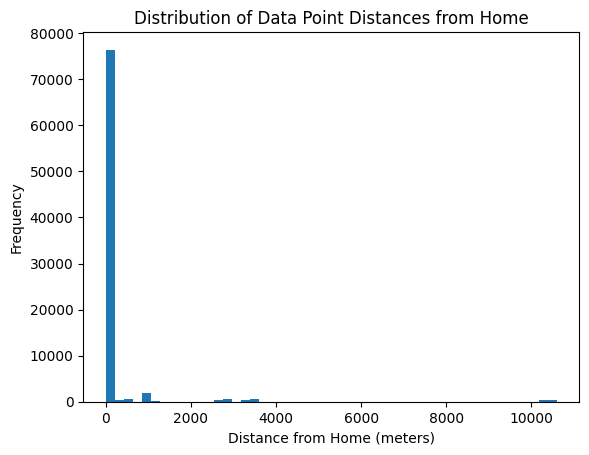

In [17]:
# Define the home coordinates
home_coordinates = [(43.801260809983425, -79.34917658657542), (43.470312409433404, -80.55422190198057)]

# Function to check if latitude and longitude are within the specified distance of home coordinates
def is_at_home(latitude, longitude):
    minimum_distance = float('inf') 
    for i in range(len(home_coordinates)):
        distance = h3.point_dist(home_coordinates[i], (latitude, longitude), unit='km')
        if distance < minimum_distance:
            minimum_distance = distance
    return minimum_distance

# Apply the function to create the 'is_at_home' feature
playback_history['distance_from_home'] = playback_history.apply(lambda row: is_at_home(row['latitudeE7'], row['longitudeE7']), axis=1)

# Plot histogram of distances from home
plt.hist(playback_history['distance_from_home'], bins=50)
plt.xlabel('Distance from Home (meters)')
plt.ylabel('Frequency')
plt.title('Distribution of Data Point Distances from Home')
plt.show()

In [18]:
playback_history['is_on_vacation'] = np.where(playback_history['distance_from_home'] > 50, 1, 0)
print(playback_history['is_on_vacation'].value_counts())

is_on_vacation
0    74850
1     7145
Name: count, dtype: int64


In [19]:
gym_coordinates = [(43.799774912305814, -79.31899782422916), (43.47219321608473, -80.54617273624429)]
gym_radius = [40, 40]

# Function to check if latitude and longitude are within the specified distance of home coordinates
def is_at_gym(latitude, longitude):
    for i in range(len(gym_coordinates)):
        distance = h3.point_dist(gym_coordinates[i], (latitude, longitude), unit='m')
        if distance <= gym_radius[i]:
            return float(1)
    return float(0)

# Apply the function to create the 'is_at_home' feature
playback_history['is_at_gym'] = playback_history.apply(lambda row: is_at_gym(row['latitudeE7'], row['longitudeE7']), axis=1)

print(playback_history['is_at_gym'].value_counts())

is_at_gym
0.0    81392
1.0      603
Name: count, dtype: int64


In [20]:
playback_history.to_csv('./csv_data/playback_history_pt2.csv')

# Weather Data: Local Toronto Data

In [21]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import h3

playback_history = pd.read_csv('./csv_data/playback_history_pt2.csv')

In [22]:
directory = './csv_data/weather data toronto/'

# Get all the CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# Read and merge the CSV files
dataframes = []
for file in csv_files:
    filepath = os.path.join(directory, file)
    df = pd.read_csv(filepath)
    dataframes.append(df)

weather_data = pd.concat(dataframes)

# Sort the merged dataframe by date
weather_data.sort_values(by='UTC_DATE', inplace=True)
weather_data['WEATHER_ENG_DESC'] = weather_data['WEATHER_ENG_DESC'].ffill()

weather_data.to_csv('./csv_data/toronto_weather_data.csv', index=False)

weather_data = weather_data[['UTC_DATE', 'TEMP', 'WEATHER_ENG_DESC', 'RELATIVE_HUMIDITY', 'WIND_SPEED', 'WINDCHILL']]


weather_data.head()

,UTC_DATE,TEMP,WEATHER_ENG_DESC,RELATIVE_HUMIDITY,WIND_SPEED,WINDCHILL
0,2020-04-16T20:00:00,2.4,NaN,53.0,16.0,NaN
1,2020-04-16T21:00:00,3.5,Mostly Cloudy,52.0,26.0,NaN
2,2020-04-16T22:00:00,1.7,Snow Showers,54.0,40.0,NaN
3,2020-04-16T23:00:00,2.6,Snow Showers,41.0,22.0,NaN
4,2020-04-17T00:00:00,1.3,Mainly Clear,44.0,13.0,NaN


In [23]:
playback_history = pd.read_csv('./csv_data/playback_history_pt2.csv')
weather_data = pd.read_csv('./csv_data/better toronto weather.csv')

# Convert date columns to datetime
playback_history['Date Played'] = pd.to_datetime(playback_history['Date Played'])
weather_data['time'] = pd.to_datetime(weather_data['time']).dt.tz_localize('UTC')

def within_location_range(latitude, longitude, location_coordinates, location_radius):
    distance = h3.point_dist(location_coordinates, (latitude, longitude), unit='km')
    return distance <= location_radius

# Define function to find closest weather data
def find_closest_weather(date_played):
    time_diff = abs(weather_data['time'] - date_played)
    closest_index = time_diff.idxmin()
    return weather_data.loc[closest_index]

weather_features = ['temperature', 'relative_humidity', 'precipitation', 'rain', 'snow_depth', 'cloud_cover', 'wind_speed', 'is_day', 'sunshine_duration']

# Initialize columns for weather data in playback_history
for column in weather_features:
    playback_history[column] = None

toronto_data_location = (43.67666666666667, -79.63055556)
skipped_rows = 0

# Use a for loop with tqdm to iterate over each row in playback_history
for i in tqdm(playback_history.index, desc="Processing weather data"):

    latitude = playback_history.at[i, 'latitudeE7']
    longitude = playback_history.at[i, 'longitudeE7']

    if not within_location_range(latitude, longitude, toronto_data_location, 100):
        skipped_rows += 1
        continue

    date_played = playback_history.at[i, 'Date Played']
    closest_weather = find_closest_weather(date_played)
    for column in weather_features:
        playback_history.at[i, column] = closest_weather[column]

print(f"Skipped {skipped_rows} rows due to location outside Toronto data range.")

Processing weather data: 100%|██████████| 81995/81995 [02:33<00:00, 534.89it/s] 

Skipped 6587 rows due to location outside Toronto data range.


In [24]:
playback_history = playback_history.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

playback_history.to_csv('./csv_data/playback_history_pt3.csv', index=False)
playback_history.head()

,Song ID,Date Played,nearest_location_time,latitudeE7,longitudeE7,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL,local_time,...,is_at_gym,temperature,relative_humidity,precipitation,rain,snow_depth,cloud_cover,wind_speed,is_day,sunshine_duration
0,5v9qXmcXDJTpBKCNBuWK3w,2021-03-12 16:47:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38,0.0,0.0,0.0,0,31.7,1,3600.0
1,5URRkOSTiK6ptNimcb3mDl,2021-03-12 16:52:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38,0.0,0.0,0.0,0,31.7,1,3600.0
2,6cT2ovEBYIdVIdjRM532dp,2021-03-12 16:56:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38,0.0,0.0,0.0,0,31.7,1,3600.0
3,25m7tvekS96VV5xZ5hyuP3,2021-03-12 16:58:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38,0.0,0.0,0.0,0,31.7,1,3600.0
4,4heEsW3208sXdv2hRLvFl9,2021-03-12 17:02:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38,0.0,0.0,0.0,0,31.7,1,3600.0


# Weather Data: Non Toronto Data

In [25]:
import pandas as pd
import numpy as np
import h3
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from scipy.spatial import cKDTree

playback_history = pd.read_csv('./csv_data/playback_history_pt3.csv')

In [26]:
missing_weather_data = playback_history[playback_history['temperature'].isnull()]

missing_weather_data.loc[:, 'Date Played'] = pd.to_datetime(missing_weather_data['Date Played'])
print(len(missing_weather_data))

missing_weather_data.head()

6587


,Song ID,Date Played,nearest_location_time,latitudeE7,longitudeE7,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL,local_time,...,is_at_gym,temperature,relative_humidity,precipitation,rain,snow_depth,cloud_cover,wind_speed,is_day,sunshine_duration
1673,0cqcRqZgkNHanWQ8slYA0v,2021-07-04 01:37:00+00:00,2021-07-04 01:36:00+00:00,43.995175,-77.707827,0.0,0.0,0.0,1.0,2021-07-03 21:36:00,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1749,5sNESr6pQfIhL3krM8CtZn,2021-07-24 19:05:00+00:00,2021-07-24 19:06:00+00:00,45.055102,-79.290721,0.0,0.0,0.0,1.0,2021-07-24 15:06:00,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1750,0sHW1jXe6Sou3437gJQNGA,2021-07-24 19:09:00+00:00,2021-07-24 19:09:00+00:00,45.105066,-79.310303,0.0,0.0,0.0,1.0,2021-07-24 15:09:00,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1751,1a3xfVZyJnlKn4t65ccBbp,2021-07-24 19:13:00+00:00,2021-07-24 19:13:00+00:00,45.179431,-79.311948,0.0,0.0,0.0,1.0,2021-07-24 15:13:00,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1a3xfVZyJnlKn4t65ccBbp,2021-07-24 19:13:00+00:00,2021-07-24 19:13:00+00:00,45.188586,-79.312543,1.0,0.0,0.0,0.0,2021-07-24 15:13:00,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Initialize Open-Meteo API client with cache and retry
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

def group_locations(missing_weather_data):
    locations_list = []
    for index in missing_weather_data.index:
        location_added = False
        latitude = missing_weather_data.at[index, 'latitudeE7']
        longitude = missing_weather_data.at[index, 'longitudeE7']
        date = missing_weather_data.at[index, 'Date Played'].date()
        for location in locations_list:
            if h3.point_dist((location['latitude'], location['longitude']), (latitude, longitude), unit='km') < 50 and (date - location['start_date']).days < 2:
                location["end_date"] = date
                location["datapoint_count"] += 1
                location_added = True
                break
        if not location_added:
            locations_list.append({"start_date": date, "end_date": date, "latitude": latitude, "longitude": longitude, "datapoint_count": 1})
    return locations_list

def fetch_weather_data(locations_list):
    url = "https://archive-api.open-meteo.com/v1/archive"
    locations_data = []
    for location in locations_list:
        params = {
            "latitude": location["latitude"],
            "longitude": location["longitude"],
            "start_date": location["start_date"],
            "end_date": location["end_date"],
            "hourly": ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snow_depth", "cloud_cover", "wind_speed_10m", "is_day", "sunshine_duration"]
        }
        response = openmeteo.weather_api(url, params=params)[0]
        hourly = response.Hourly()
        hourly_data = {
            "date": pd.date_range(start=pd.to_datetime(hourly.Time(), unit="s", utc=True), 
                                  end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True), 
                                  freq=pd.Timedelta(seconds=hourly.Interval()), inclusive="left"),
            "temperature": hourly.Variables(0).ValuesAsNumpy(),
            "relative_humidity": hourly.Variables(1).ValuesAsNumpy(),
            "precipitation": hourly.Variables(2).ValuesAsNumpy(),
            "rain": hourly.Variables(3).ValuesAsNumpy(),
            "snow_depth": hourly.Variables(4).ValuesAsNumpy(),
            "cloud_cover": hourly.Variables(5).ValuesAsNumpy(),
            "wind_speed": hourly.Variables(6).ValuesAsNumpy(),
            "is_day": hourly.Variables(7).ValuesAsNumpy(),
            "sunshine_duration": hourly.Variables(8).ValuesAsNumpy()
        }
        hourly_dataframe = pd.DataFrame(data=hourly_data)
        locations_data.append(hourly_dataframe)
    return locations_data

def fill_missing_weather_data(missing_weather_data, locations_list, locations_data):
    for index in missing_weather_data.index:
        latitude = missing_weather_data.at[index, 'latitudeE7']
        longitude = missing_weather_data.at[index, 'longitudeE7']
        date = missing_weather_data.at[index, 'Date Played'].date()
        for location, hourly_data in zip(locations_list, locations_data):
            if h3.point_dist((location['latitude'], location['longitude']), (latitude, longitude), unit='km') < 50 and (date - location['start_date']).days < 2:
                date_played = missing_weather_data.at[index, 'Date Played']
                closest_hourly_data = hourly_data.iloc[(hourly_data['date'] - date_played).abs().argsort()[:1]]
                for column in weather_features:
                    missing_weather_data.at[index, column] = closest_hourly_data[column].values[0]
                break

# delete in prod
weather_features = ['temperature', 'relative_humidity', 'precipitation', 'rain', 'snow_depth', 'cloud_cover', 'wind_speed', 'is_day', 'sunshine_duration']

locations_list = group_locations(missing_weather_data)
print(len(locations_list))

locations_data = fetch_weather_data(locations_list)
fill_missing_weather_data(missing_weather_data, locations_list, locations_data)
playback_history.update(missing_weather_data)

print(len(missing_weather_data[missing_weather_data['temperature'].isnull()]))

138
0


In [28]:
playback_history.to_csv('./csv_data/playback_history_pt4.csv', index=False)
playback_history.head()

,Song ID,Date Played,nearest_location_time,latitudeE7,longitudeE7,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL,local_time,...,is_at_gym,temperature,relative_humidity,precipitation,rain,snow_depth,cloud_cover,wind_speed,is_day,sunshine_duration
0,5v9qXmcXDJTpBKCNBuWK3w,2021-03-12 16:47:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38.0,0.0,0.0,0.0,0.0,31.7,1.0,3600.0
1,5URRkOSTiK6ptNimcb3mDl,2021-03-12 16:52:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38.0,0.0,0.0,0.0,0.0,31.7,1.0,3600.0
2,6cT2ovEBYIdVIdjRM532dp,2021-03-12 16:56:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38.0,0.0,0.0,0.0,0.0,31.7,1.0,3600.0
3,25m7tvekS96VV5xZ5hyuP3,2021-03-12 16:58:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38.0,0.0,0.0,0.0,0.0,31.7,1.0,3600.0
4,4heEsW3208sXdv2hRLvFl9,2021-03-12 17:02:00+00:00,2021-03-12 15:55:00+00:00,43.801276,-79.349211,0.0,0.0,0.0,1.0,2021-03-12 10:55:00,...,0.0,10.3,38.0,0.0,0.0,0.0,0.0,31.7,1.0,3600.0


## Final Step: Normalize Features!

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

playback_history = pd.read_csv('./csv_data/playback_history_pt4.csv')

In [30]:
features_to_standardize  = ["temperature", "relative_humidity", "precipitation", "rain", "snow_depth", "wind_speed"]
playback_history[features_to_standardize] = scaler.fit_transform(playback_history[features_to_standardize])

playback_history['cloud_cover'] = playback_history['cloud_cover'] / 100
playback_history['sunshine_duration'] = playback_history['sunshine_duration'] / 3600

playback_history.drop(columns=['Date Played', 'nearest_location_time', 'latitudeE7', 'longitudeE7', 'local_time', 'distance_from_home'], inplace=True)

playback_history.to_csv('./csv_data/playback_history_final.csv', index=False)

playback_history.head()

,Song ID,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL,sin_time,cos_time,month_April,month_August,month_December,...,is_at_gym,temperature,relative_humidity,precipitation,rain,snow_depth,cloud_cover,wind_speed,is_day,sunshine_duration
0,5v9qXmcXDJTpBKCNBuWK3w,0.0,0.0,0.0,1.0,0.279829,-0.96005,0.0,0.0,0.0,...,0.0,0.037209,-1.698164,-0.231361,-0.204927,-0.401963,0.0,2.863946,1.0,1.0
1,5URRkOSTiK6ptNimcb3mDl,0.0,0.0,0.0,1.0,0.279829,-0.96005,0.0,0.0,0.0,...,0.0,0.037209,-1.698164,-0.231361,-0.204927,-0.401963,0.0,2.863946,1.0,1.0
2,6cT2ovEBYIdVIdjRM532dp,0.0,0.0,0.0,1.0,0.279829,-0.96005,0.0,0.0,0.0,...,0.0,0.037209,-1.698164,-0.231361,-0.204927,-0.401963,0.0,2.863946,1.0,1.0
3,25m7tvekS96VV5xZ5hyuP3,0.0,0.0,0.0,1.0,0.279829,-0.96005,0.0,0.0,0.0,...,0.0,0.037209,-1.698164,-0.231361,-0.204927,-0.401963,0.0,2.863946,1.0,1.0
4,4heEsW3208sXdv2hRLvFl9,0.0,0.0,0.0,1.0,0.279829,-0.96005,0.0,0.0,0.0,...,0.0,0.037209,-1.698164,-0.231361,-0.204927,-0.401963,0.0,2.863946,1.0,1.0


## The Final Dataset!

In [31]:
print("number of rows with a null value" + str(playback_history.isnull().sum()))

playback_history.describe()

number of rows with a null valueSong ID                      0
activity_IN_VEHICLE          0
activity_ON_BICYCLE          0
activity_ON_FOOT             0
activity_STILL               0
sin_time                     0
cos_time                     0
month_April                  0
month_August                 0
month_December               0
month_February               0
month_January                0
month_July                   0
month_June                   0
month_March                  0
month_May                    0
month_November               0
month_October                0
month_September              0
season_0.0                   0
season_1.0                   0
season_2.0                   0
season_3.0                   0
is_weekend                   0
day_0.0                      0
day_1.0                      0
day_2.0                      0
day_3.0                      0
day_4.0                      0
day_5.0                      0
day_6.0                      0
is_at_h

,activity_IN_VEHICLE,activity_ON_BICYCLE,activity_ON_FOOT,activity_STILL,sin_time,cos_time,month_April,month_August,month_December,month_February,...,is_at_gym,temperature,relative_humidity,precipitation,rain,snow_depth,cloud_cover,wind_speed,is_day,sunshine_duration
count,81995.000000,81995.000000,81995.000000,81995.000000,81995.000000,81995.000000,81995.000000,81995.000000,81995.000000,81995.000000,...,81995.000000,8.199500e+04,8.199500e+04,8.199500e+04,8.199500e+04,8.188200e+04,81995.000000,8.199500e+04,81995.000000,81995.000000
mean,0.028111,0.017708,0.024416,0.929764,-0.400516,0.035064,0.094152,0.073712,0.085359,0.073395,...,0.007354,1.448902e-16,-7.403744e-17,9.254950e-17,6.828559e-17,-1.915156e-16,0.520726,-1.727071e-16,0.548192,0.383007
std,0.165292,0.131890,0.154338,0.255546,0.542698,0.737459,0.292042,0.261303,0.279417,0.260785,...,0.085441,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,0.385676,1.000006e+00,0.497675,0.470632
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-3.492073e+00,-2.946946e+00,-2.313614e-01,-2.049268e-01,-4.019628e-01,0.000000,-1.956370e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,-0.889017,-0.737277,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.109882e-01,-7.331963e-01,-2.313614e-01,-2.049268e-01,-4.019628e-01,0.140000,-7.398862e-01,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,-0.551937,0.069756,0.000000,0.000000,0.000000,0.000000,...,0.000000,-6.028452e-02,4.720269e-03,-2.313614e-01,-2.049268e-01,-4.019628e-01,0.470000,-1.772627e-01,1.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.801254,0.000000,0.000000,0.000000,0.000000,...,0.000000,8.269107e-01,7.993997e-01,-2.313614e-01,-2.049268e-01,-1.981576e-01,0.940000,5.678335e-01,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.999962,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.699185e+00,1.821130e+00,2.618702e+01,2.737258e+01,5.508387e+00,1.000000,4.354138e+00,1.000000,1.000000
